# Implementation of the TD3 algorithm


Reference Paper:
[1] Fujimoto, S., van Hoof, H., & Meger, D. (2018). Addressing function approximation error in actor-critic methods. arXiv. https://arxiv.org/abs/1802.09477

This notebook only contains the training code, the architectures and other utils are found in the `src` dir.

In [6]:
import gymnasium as gym
import numpy as np 
import torch 
import matplotlib.pyplot as plt

from td3.model.td3 import TD3
from td3.utils.metrics import RollingAverage
from td3.utils.replay import ReplayBuffer

from copy import deepcopy
from tqdm import tqdm
from typing import List

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
def validation_step(
    env: gym.Env,
    agent: TD3,  
    runs: int = 10, 
    device: str = 'cpu'
) -> List[float]:
    rewards = []
    for _ in range(runs):
        obs, _ = env.reset()
        done = False
        ep_reward = 0 
        
        while not done:
            with torch.no_grad():
                obs_torch = torch.as_tensor(obs, dtype=torch.float).view(1, -1).to(device)
                action = agent.actor(obs_torch).view(-1).cpu().numpy()
                
                obs_prime, reward, terminated, truncated, _ = env.step(action)
                ep_reward += reward
                
                obs = obs_prime
                done = terminated or truncated

        rewards.append(ep_reward)
        
    return rewards


def train(
    env: gym.Env, 
    agent: TD3, 
    game_name: str, 
    timesteps: int = 1000000, 
    val_freq: int = 5000, 
    batch_size: int = 256, 
    buffer_size: int = int(1e6),
    preload: int = 1000, 
    window: int = 20, 
    num_val_runs: int = 10, 
    device: str = 'cpu'
) -> RollingAverage:
    
    obs_space = np.prod(env.observation_space.shape)
    action_space = np.prod(env.action_space.shape)
    replay = ReplayBuffer(obs_space, action_space, buffer_size, device)
    
    metrics = RollingAverage(window)
    
    env_test = deepcopy(env)
    
    obs, _ = env.reset()
    done = False
    for _ in tqdm(range(preload)):
        action = env.action_space.sample()
        obs_prime, reward, terminated, truncated, _ = env.step(action)
        
        done = terminated or truncated
        replay.update(obs, action, reward, obs_prime, int(done))
        
        obs = obs_prime
        if done: 
            obs, _ = env.reset()
            done = False
    
    obs, _ = env.reset()
    done = False
    
    for step in range(1, timesteps+1):
        action = agent.explore_action(obs)
        obs_prime, reward, terminated, truncated, _ = env.step(action)
        
        done = terminated or truncated
        replay.update(obs, action, reward, obs_prime, int(done))
        
        obs = obs_prime
        if done:
            obs, _ = env.reset()
            done = False
        
        # update step 
        batch_obs, batch_actions, batch_rewards, batch_next_obs, batch_dones = replay.sample(batch_size)
        agent.update(
            batch_obs, 
            batch_actions, 
            batch_rewards, 
            batch_next_obs, 
            batch_dones
        )
        
        if step % val_freq == 0 or step == 1:
            val_rewards = validation_step(env_test, agent, num_val_runs, device)
            metrics.update(val_rewards)
        
        avg_reward = float(np.mean(val_rewards))
        print(f'Timestep: {step} | Average Val Reward: {avg_reward:.4f}', end='\r')

    agent.save(game_name)
    env.close()
    env_test.close()
    
    return metrics

def plot_results(scores, timesteps, val_freq, game_name):
    vars_low = []
    vars_high = []
    q=10

    for i in range(scores.shape[0]):
        vars_low.append(np.percentile(scores[i, :], q=q))
        vars_high.append(np.percentile(scores[i, :], q=100-q))

    mean_scores = np.mean(scores, axis=1) 
    plt.style.use('ggplot')   
    
    color = 'r'
    xs = np.arange(0, timesteps+val_freq, val_freq)
    plt.plot(xs, mean_scores, label='Average Val Score', color=color)
    plt.plot(xs, vars_low, alpha=0.1, color=color)
    plt.plot(xs, vars_high, alpha=0.1, color=color)
    plt.fill_between(xs, vars_low, vars_high, alpha=0.2, color=color)
    plt.legend()
    plt.grid(True)
    plt.title(f'{game_name} TD3 Results')
    plt.ylabel('Cumm. Reward')
    plt.xlabel('Timestep')
    plt.show()
    

Set up the environment and the agent. First let's test on a simpler environment such as Pendulum 

In [3]:
env_pend = gym.make('Pendulum-v1')

obs_space = np.prod(env_pend.observation_space.shape)
action_space = np.prod(env_pend.action_space.shape)
pend_agent = TD3(
    obs_space, 
    action_space, 
    env_pend.action_space.high[0]
)

metrics_pend = train(
    env_pend, 
    pend_agent,
    'Pendulum', 
    timesteps=50000,
    preload=5000, 
    val_freq=5000,
    num_val_runs=25
)

100%|██████████| 5000/5000 [00:00<00:00, 8243.95it/s]


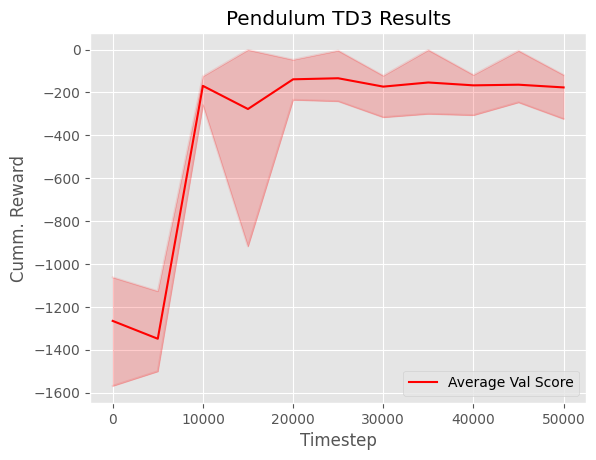

In [4]:
plot_results(metrics_pend.get_values, 50000, 5000, 'Pendulum')

In [ ]:
env_cheetah = gym.make('HalfCheetah-v5')

obs_space = np.prod(env_cheetah.observation_space.shape)
action_space = np.prod(env_cheetah.action_space.shape)
pend_cheetah = TD3(
    obs_space, 
    action_space, 
    env_cheetah.action_space.high[0],
    device=device
)

metrics_cheetah = train(
    env_cheetah, 
    pend_cheetah, 
    'Cheetah',
    timesteps=1000000,
    preload=int(25e3), 
    val_freq=5000,
    num_val_runs=15, 
    device=device
)

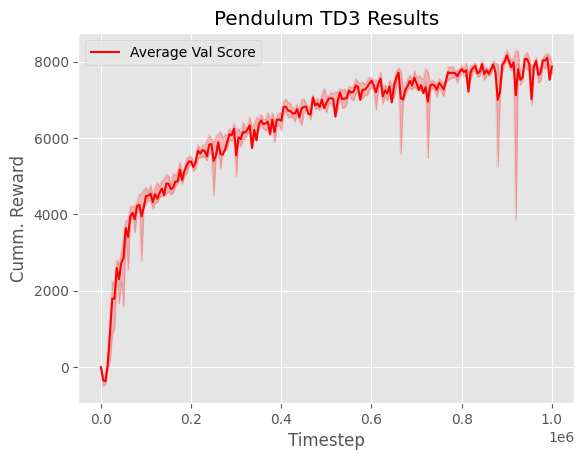

In [ ]:
plot_results(metrics_cheetah.get_values, 1000000, 5000, 'HalfCheetah')

In [ ]:
env_hopper = gym.make('Hopper-v5')

obs_space = np.prod(env_hopper.observation_space.shape)
action_space = np.prod(env_hopper.action_space.shape)
pend_hopper = TD3(
    obs_space, 
    action_space, 
    env_hopper.action_space.high[0],
    device=device
)

metrics_hopper = train(
    env_hopper, 
    pend_hopper, 
    'Hopper',
    timesteps=1000000,
    preload=int(25e3), 
    val_freq=5000,
    num_val_runs=10, 
    device=device
)

100%|██████████| 10000/10000 [00:05<00:00, 1705.67it/s]


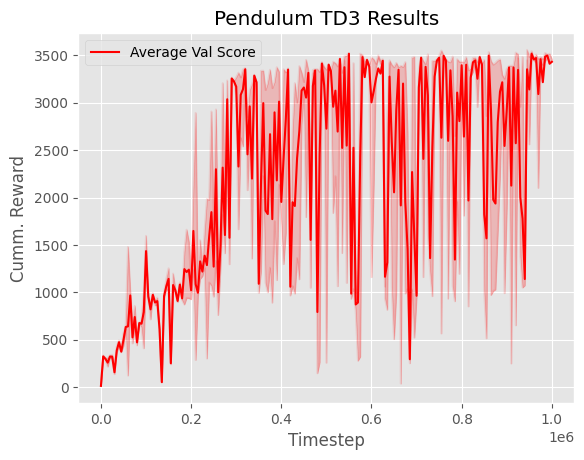

In [ ]:
plot_results(metrics_hopper.get_values, 1000000, 5000, 'Hopper')